# Datasets comparison between CAMS and IASI (L2)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (CO, O3 or SO2)
component_nom = 'CO'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'iasi'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2019-05-14'
end_date = '2019-05-15'

# Define extent
area_name = 'Global'
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 90

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: ('2019-05-14', '2019-05-15')
SEARCH BOUNDING BOX
Latitudes: from -90 to 90
Longitudes: from -180 to 180


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'Single', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-05-14 2019-05-15
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-11T10:48 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


In [11]:
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2019-05-14 2019-05-15
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] 2019-05-14 ... 2019-05-15T21:00:00
Data variables:
    component   (time, step, latitude, longitude) float32 5.961e+17 ... 1.935...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-11T10:48 GRIB to CDM+CF via cfgrib-0.9.9...

### Get CAMS levels (total or tropospheric)

In [12]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be compared to the total sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900, step: 8, time: 2)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2019-05-14 2019-05-15
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] 2019-05-14 ... 2019-05-15T21:00:00
Data variables:
    component   (time, step, latitude, longitude) float32 5.961e+17 ... 1.935...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-11T10:48 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

### Download and read data as xarray

In [13]:
dates = sensor_download(sensor, sensor_type, component_nom, dates)

RESULTS
For 2019-05-14:
IASI_METOPA_L2_CO_20190514_ULB-LATMOS_V6.4.0.nc was downloaded.
IASI_METOPB_L2_CO_20190514_ULB-LATMOS_V6.4.0.nc was downloaded.
IASI_METOPC_L2_CO_20190514_ULB-LATMOS_V6.4.0.nc is not available.
For 2019-05-15:
IASI_METOPA_L2_CO_20190515_ULB-LATMOS_V6.4.0.nc was downloaded.
IASI_METOPB_L2_CO_20190515_ULB-LATMOS_V6.4.0.nc was downloaded.
IASI_METOPC_L2_CO_20190515_ULB-LATMOS_V6.4.0.nc is not available.


In [14]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

/tmp/ipykernel_2148314/1022231424.py:85: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_2148314/1022231424.py:85: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.DataArray 'sensor_column' (time: 2, latitude: 180, longitude: 360)>
array([[[       nan, 0.01826084, 0.01632495, ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.01748691, ..., 0.01544288,
                nan,        nan],
        [       nan, 0.01453218, 0.01418675, ..., 0.01458035,
         0.01337964,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan, 0.01708435, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  (time) datetime64[ns] 2019-05-14 2019-05-15
  * time        (time) datetime64[ns] 2019-05-14 2019-05-15
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [15]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component_nom)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.DataArray 'sensor_column' (time: 2, latitude: 180, longitude: 360)>
array([[[           nan, 1.09969359e+18, 9.83111367e+17, ...,
                    nan,            nan,            nan],
        [           nan,            nan, 1.05308639e+18, ...,
         9.29991603e+17,            nan,            nan],
        [           nan, 8.75148154e+17, 8.54346069e+17, ...,
         8.78048977e+17, 8.05740705e+17,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan, 1.02884375e+18, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  (time) datetime64[ns] 2019-05-14 2019-05-15
  * time        (time) datetime64[ns] 2019-05-14 2019-05-15
Attributes:
    units:    molec cm-2

## 4. Match data

In [16]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR DATE: 2019-05-14
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR DATE: 2019-05-15
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.


,latitude,longitude,delta_time,time,sensor_column,step_index,model_column
0,-89.5,-179.5,2019-05-14,2019-05-14,NaN,0,5.927245e+17
1,-89.5,-178.5,2019-05-14,2019-05-14,1.099694e+18,0,5.929879e+17
2,-89.5,-177.5,2019-05-14,2019-05-14,9.831114e+17,0,5.931665e+17
3,-89.5,-176.5,2019-05-14,2019-05-14,NaN,0,5.934389e+17
4,-89.5,-175.5,2019-05-14,2019-05-14,NaN,0,5.936165e+17
...,...,...,...,...,...,...,...
64795,89.5,175.5,2019-05-15,2019-05-15,NaN,0,1.918706e+18
64796,89.5,176.5,2019-05-15,2019-05-15,NaN,0,1.918566e+18
64797,89.5,177.5,2019-05-15,2019-05-15,NaN,0,1.918358e+18
64798,89.5,178.5,2019-05-15,2019-05-15,NaN,0,1.918224e+18


## 5. Merge data and calculate difference

In [17]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
-89.5    -179.5    2019-05-14  5.927245e+17            NaN           NaN   
         -178.5    2019-05-14  5.929879e+17   1.099694e+18  5.067057e+17   
         -177.5    2019-05-14  5.931665e+17   9.831114e+17  3.899449e+17   
         -176.5    2019-05-14  5.934389e+17            NaN           NaN   
         -175.5    2019-05-14  5.936165e+17            NaN           NaN   
...                                     ...            ...           ...   
 89.5     175.5    2019-05-15  1.918706e+18            NaN           NaN   
          176.5    2019-05-15  1.918566e+18            NaN           NaN   
          177.5    2019-05-15  1.918358e+18            NaN           NaN   
          178.5    2019-05-15  1.918224e+18            NaN           NaN   
          179.5    2019-05-15  1.918032e+18            NaN           NaN   

                               relative_difference  
latitude longitude time                             
-89.5    -179.5    2019-05-14                  NaN  
         -178.5    2019-05-14            -0.460770  
         -177.5    2019-05-14            -0.396644  
         -176.5    2019-05-14                  NaN  
         -175.5    2019-05-14                  NaN  
...                                            ...  
 89.5     175.5    2019-05-15                  NaN  
          176.5    2019-05-15                  NaN  
          177.5    2019-05-15                  NaN  
          178.5    2019-05-15                  NaN  
          179.5    2019-05-15                  NaN  

[129600 rows x 4 columns]

In [18]:
descr_stats_table = merge_df.describe()
descr_stats_table

,model_column,sensor_column,difference,relative_difference
count,1.296000e+05,1.007170e+05,1.007170e+05,100717.000000
mean,1.491644e+18,1.759820e+18,2.781876e+17,-0.139512
std,5.473254e+17,5.042096e+18,5.008393e+18,0.153750
min,4.477490e+17,5.899832e+17,-1.837246e+19,-0.998997
25%,1.037024e+18,1.192743e+18,7.375575e+16,-0.227108
50%,1.488073e+18,1.721975e+18,2.301120e+17,-0.134631
75%,1.920487e+18,2.168193e+18,3.985761e+17,-0.047397
max,2.040160e+19,1.587832e+21,1.586240e+21,9.054318


## 6. Show comparison plots

### Select plot dates

In [19]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2019-05-14' '2019-05-15']


### Select plot extent

In [20]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 90))


### Compare CAMS and IASI total columns

Frame length between -180 and 180 should be one of these options: [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45, 60, 72, 90, 120, 180, 360]
Frame length between -90 and 90 should be one of these options: [1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 18, 20, 30, 36, 45, 60, 90, 180]


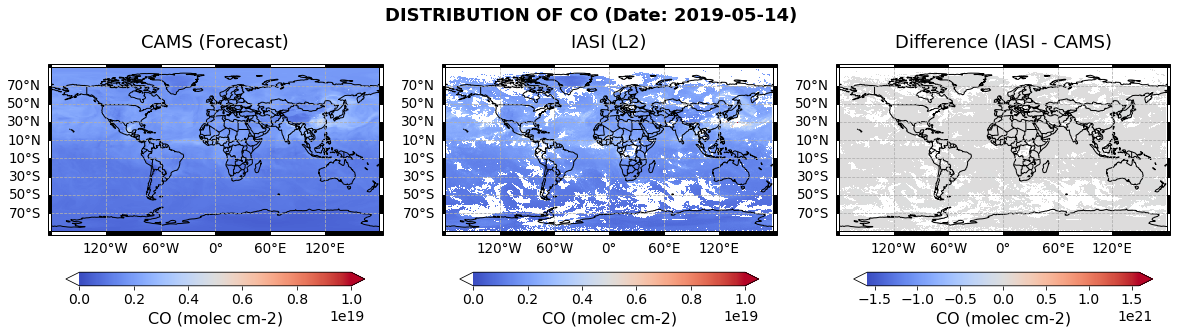

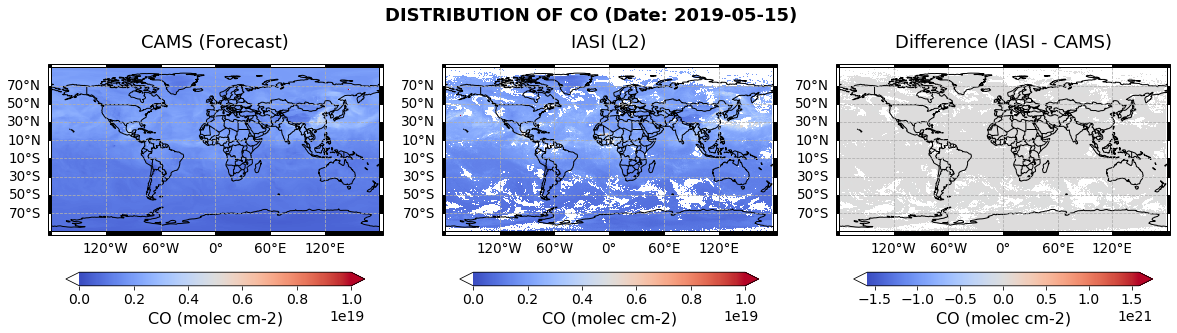

In [21]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 1*10**19

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale =  'coolwarm'

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 60
height_lat = 20

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 0.9, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific coordinates

model_column  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2019-05-14  1.951117e+18   
                      50.5     17.5      2019-05-15  2.006090e+18   
4          10         3.5      9.5       2019-05-14  2.256455e+18   
                                         2019-05-15  2.082264e+18   
20         30         19.5     29.5      2019-05-14  2.036077e+18   
                                         2019-05-15  2.032823e+18   

                                                     sensor_column  \
lat_search lon_search latitude longitude time                        
50         15         49.5     14.5      2019-05-14   1.728451e+18   
                      50.5     17.5      2019-05-15   2.228518e+18   
4          10         3.5      9.5       2019-05-14   2.928292e+18   
                                         2019-05-15   2.865805e+18   
20         30         19.5     29.5      2019-05-14   2.121149e+18   
                                         2019-05-15   2.419980e+18   

                                                       difference  \
lat_search lon_search latitude longitude time                       
50         15         49.5     14.5      2019-05-14 -2.226652e+17   
                      50.5     17.5      2019-05-15  2.224271e+17   
4          10         3.5      9.5       2019-05-14  6.718368e+17   
                                         2019-05-15  7.835412e+17   
20         30         19.5     29.5      2019-05-14  8.507169e+16   
                                         2019-05-15  3.871566e+17   

                                                     relative_difference  
lat_search lon_search latitude longitude time                             
50         15         49.5     14.5      2019-05-14             0.128824  
                      50.5     17.5      2019-05-15            -0.099809  
4          10         3.5      9.5       2019-05-14            -0.229430  
                                         2019-05-15            -0.273411  
20         30         19.5     29.5      2019-05-14            -0.040106  
                                         2019-05-15            -0.159983

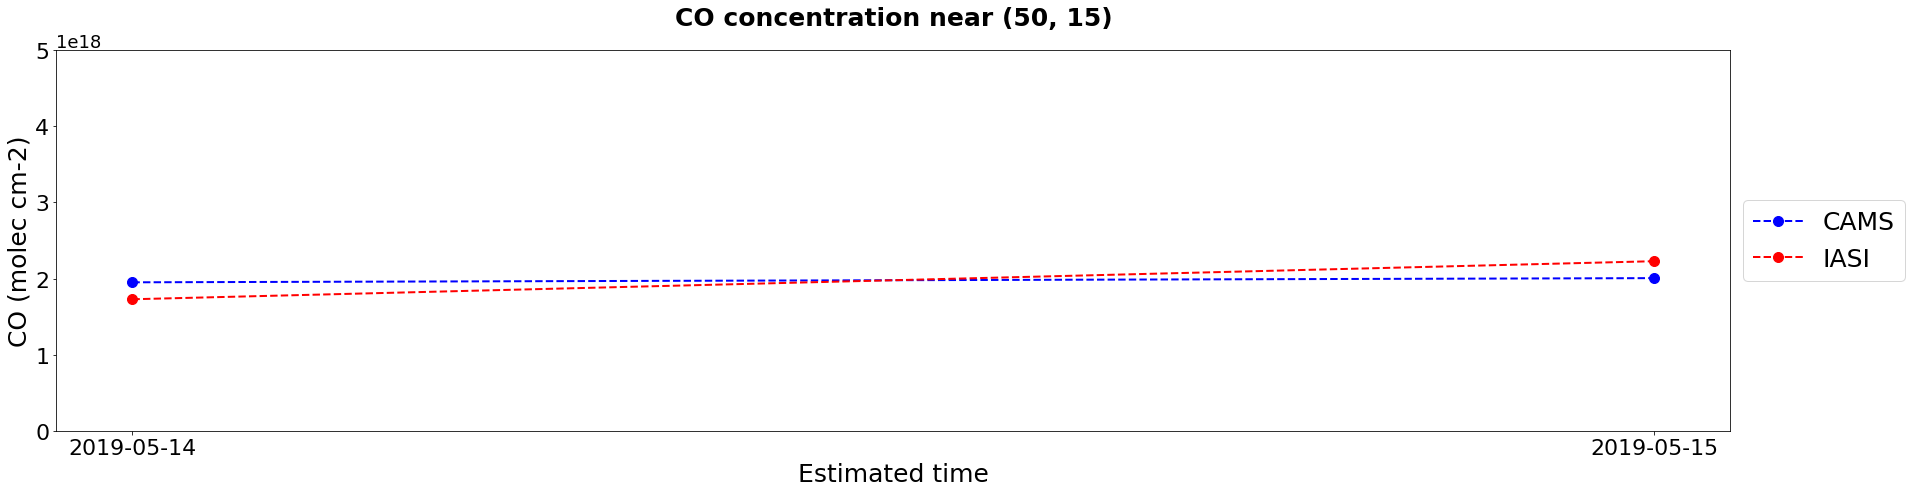

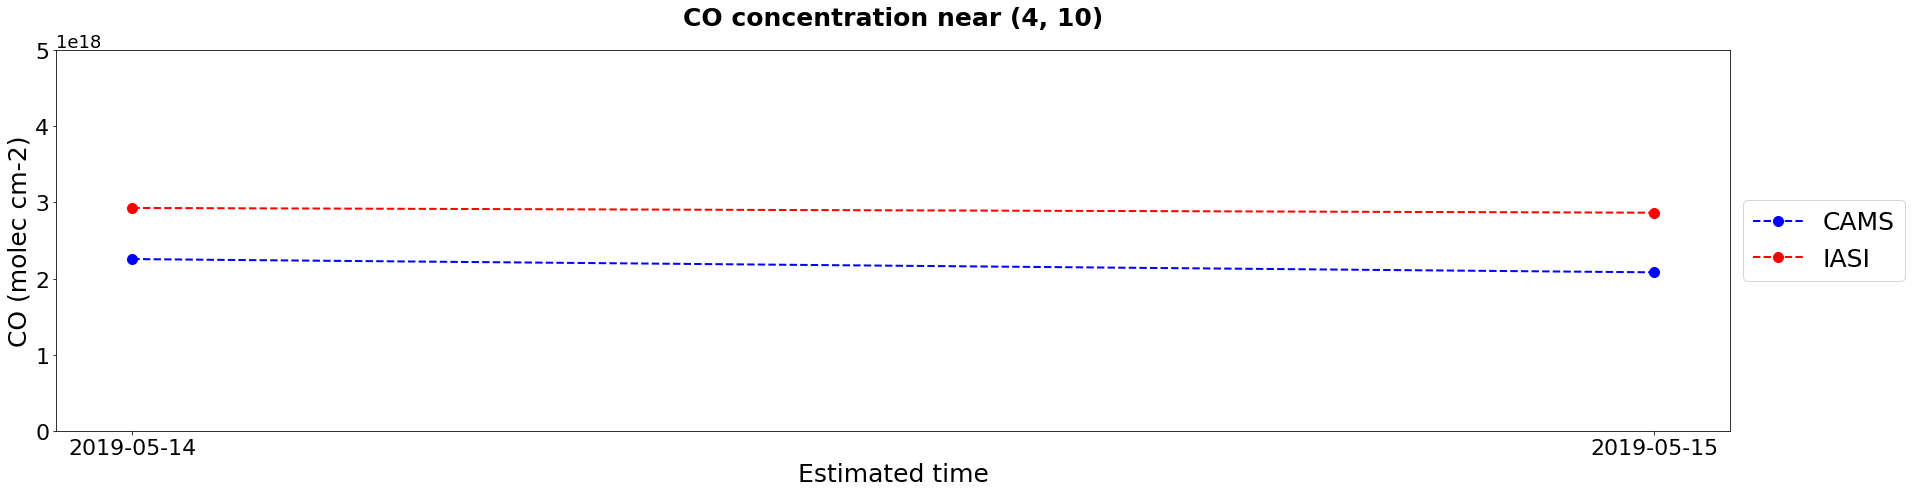

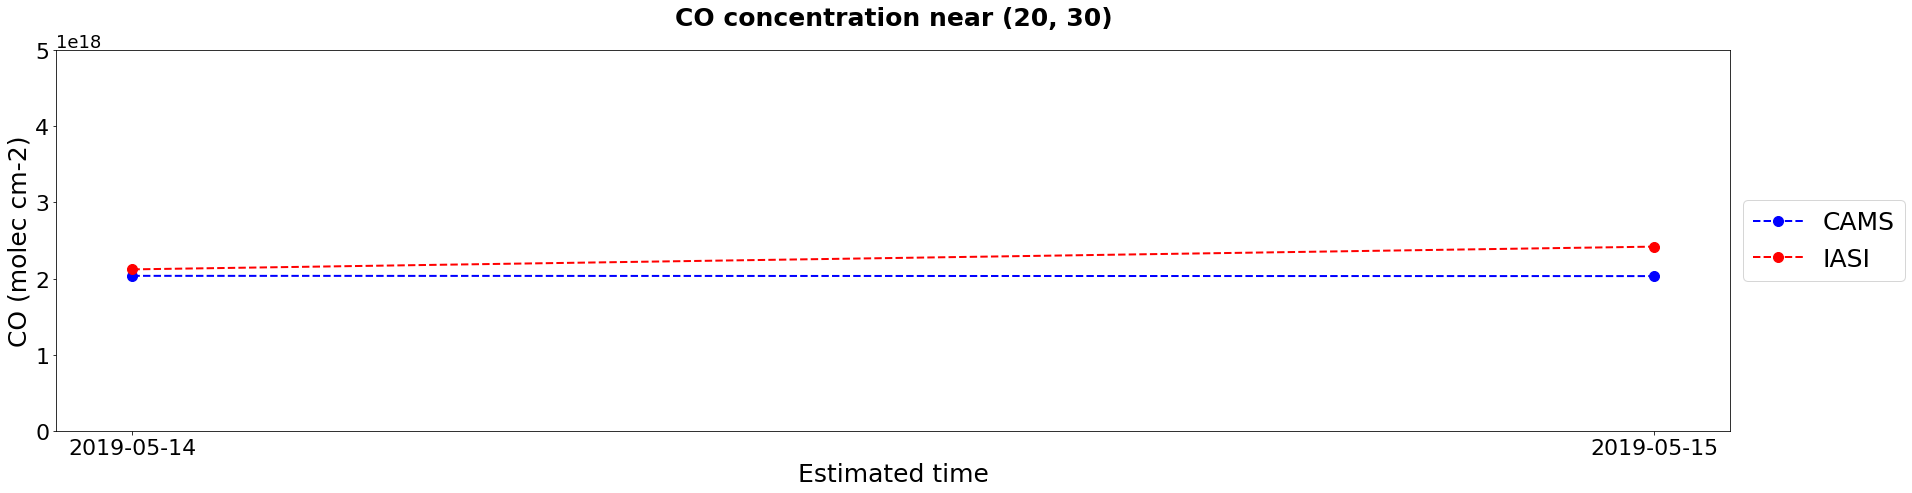

In [22]:
coords_search_list = (50, 15,
                      4, 10,
                      20, 30)
ymin = 0
ymax = 0.5*10**19
xticks = plot_dates
timeseries_table = timeseries(merge_df.dropna(), coords_search_list, component_nom, 
                              sensor, sensor_type, model, plot_dates, units, ymin, ymax, xticks)
timeseries_table

## 8. Scatter plots by bbox

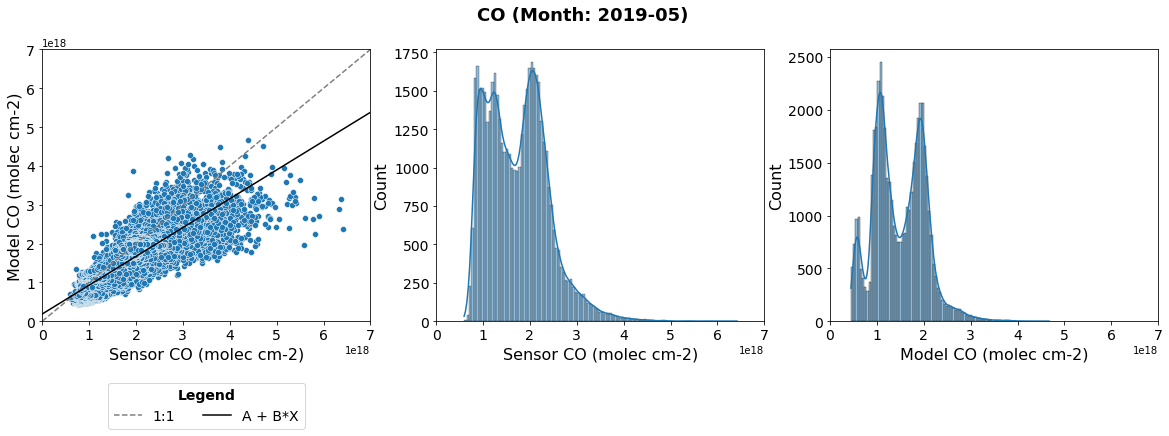

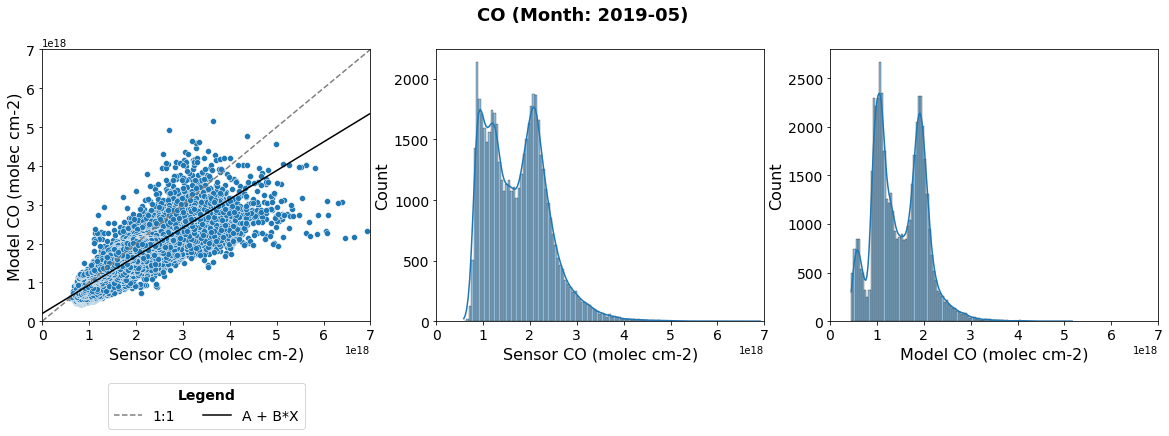

,Period,Location,A,B,R2,RMSE,MSE
0,2019-05-14,"((-180, -90), (180, 90))",0.742119,1.860987e+17,0.777680,2.583247e+17,6.673163e+34
1,2019-05-15,"((-180, -90), (180, 90))",0.736400,1.988184e+17,0.796565,2.460257e+17,6.052863e+34


In [23]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = 0
lim_max = 0.7*10**19

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 9. Scatter plots by season

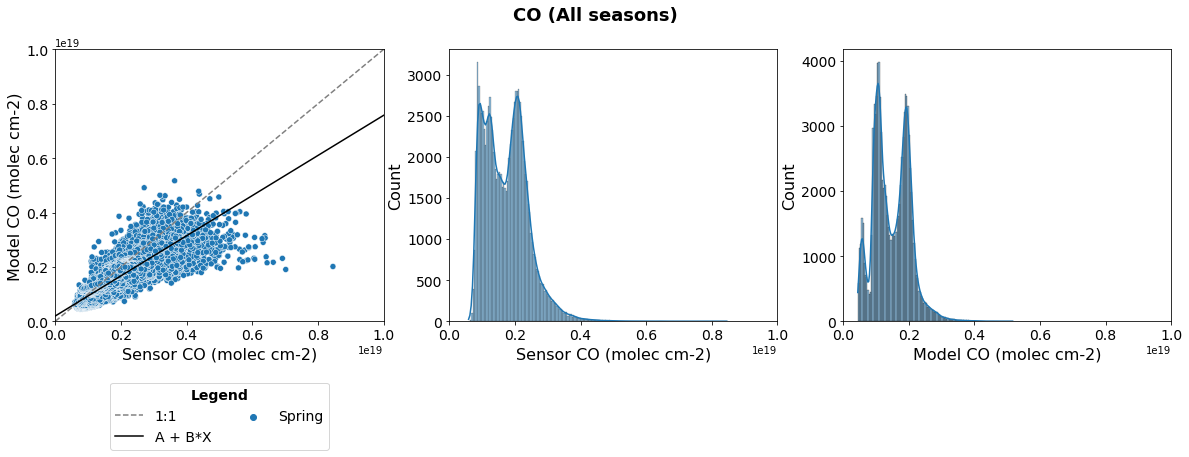

,Period,Location,A,B,R2,RMSE,MSE
0,[Spring],"((-180, -90), (180, 90))",0.737999,1.946319e+17,0.786373,2.526480e+17,6.383102e+34


In [24]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 0
lim_max = 1*10**19

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 10. Scatter plots by country (Google API required!)

In [25]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\nsummary\n"